This Notebook main goal is to orginize the scraped data to a tensor structure ready for train/test splitting.


# INSTALL/IMPORT PACKAGES


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Dense, Dropout, TimeDistributed, GlobalAveragePooling1D, BatchNormalization, LSTM, Bidirectional, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from matplotlib.colors import Normalize

# Import Raw Data

## Download Raw Data

In [2]:
!gdown --id 1890O59C3QwzdPDT2zb0fNWlKh1cN0lQ- -O previous_year_data.json

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1890O59C3QwzdPDT2zb0fNWlKh1cN0lQ-
To: /content/previous_year_data.json
100% 6.83M/6.83M [00:00<00:00, 141MB/s]


## Load Raw Data

In [3]:
data_path = '/content/previous_year_data.json'

with open(data_path, 'r') as json_data:
    data = json.load(json_data)

print("Sample player data:", json.dumps(data['LAL_2020']["players"][0], indent=4))


Sample player data: {
    "position": "PF",
    "age": 23,
    "games": 70,
    "gamesStarted": 68,
    "minutesPg": 2314.0,
    "fieldGoals": 496,
    "fieldAttempts": 1087,
    "fieldPercent": 0.456,
    "threeFg": 128,
    "threeAttempts": 422,
    "threePercent": 0.303,
    "twoFg": 368,
    "twoAttempts": 665,
    "twoPercent": 0.553,
    "effectFgPercent": 0.515,
    "ft": 188,
    "ftAttempts": 250,
    "ftPercent": 0.752,
    "offensiveRb": 60,
    "defensiveRb": 322,
    "totalRb": 382,
    "assists": 178,
    "steals": 41,
    "blocks": 26,
    "turnovers": 133,
    "personalFouls": 170,
    "points": 1308
}


# Data Preproccessing

## Define Global Constants

In [4]:
unwanted_stats = ["id", "playerName", "team", "season", "playerId", "gamesStarted"]
per_game_stats = [
    "points", "assists", "steals", "blocks", "turnovers", "personalFouls",
    "offensiveRb", "defensiveRb", "totalRb", "fieldGoals", "fieldAttempts",
    "threeFg", "threeAttempts", "twoFg", "twoAttempts", "ft", "ftAttempts"
]
per_minute_stats = per_game_stats
years_to_remove = [1996, 2023, 2024]  # Now excluding 1996, 2023, and 2024 from training
team_year_filters = {"TOT": None}  # Remove all TOT team

###Data Preperation

In [5]:
# Remove specific years from the dataset
def remove_year_data(json_data, years):
    filtered_data = json_data.copy()
    for year in years:
        year_suffix = f"_{year}"
        for key in list(filtered_data.keys()):
            if key.endswith(year_suffix):
                del filtered_data[key]
    return filtered_data

# Extract team data for specific years
def extract_year_data(json_data, years):
    extracted_data = {}
    for year in years:
        year_suffix = f"_{year}"
        for key in list(json_data.keys()):
            if key.endswith(year_suffix):
                extracted_data[key] = json_data[key]
    return extracted_data

# Create filtered dataset for training (excludes 1996, 2023, 2024)
filtered_data = remove_year_data(data, years_to_remove)

# Extract 2023 data for evaluation
data_2023 = extract_year_data(data, [2023])

## Helper Functions (Utils)

In [6]:
def create_players_df(team_data, team_key):
    """Creates a DataFrame from team data."""
    labels = team_data.get("labels", [])
    player_list = team_data.get("players", [])
    df = pd.DataFrame(player_list)

    # Extract team and season information
    team_name, season = team_key.split("_")
    df["team"] = team_name
    df["season"] = int(season)

    return df, labels

def remove_unwanted_stats(df, stats_to_remove):
    """Removes unwanted statistic columns."""
    return df.drop(columns=stats_to_remove, errors="ignore")

def normalize_columns(df, cols, divisor_col):
    """Normalizes columns by dividing by a divisor column."""
    df = df.copy()
    for col in cols:
        if col in df.columns and divisor_col in df.columns:
            df[col] = df.apply(lambda row: row[col] / row[divisor_col] if row[divisor_col] != 0 else 0, axis=1)
    return df

def add_derived_features(df):
    """Add derived features that might help the model discriminate between teams better."""
    # Shooting percentages
    if all(col in df.columns for col in ["fieldGoals", "fieldAttempts"]):
        df["fg_percentage"] = df.apply(lambda row: row["fieldGoals"] / row["fieldAttempts"] if row["fieldAttempts"] > 0 else 0, axis=1)

    if all(col in df.columns for col in ["threeFg", "threeAttempts"]):
        df["three_percentage"] = df.apply(lambda row: row["threeFg"] / row["threeAttempts"] if row["threeAttempts"] > 0 else 0, axis=1)

    if all(col in df.columns for col in ["ft", "ftAttempts"]):
        df["ft_percentage"] = df.apply(lambda row: row["ft"] / row["ftAttempts"] if row["ftAttempts"] > 0 else 0, axis=1)

    # Efficiency metrics
    if all(col in df.columns for col in ["points", "fieldAttempts"]):
        df["points_per_attempt"] = df.apply(lambda row: row["points"] / row["fieldAttempts"] if row["fieldAttempts"] > 0 else 0, axis=1)

    if all(col in df.columns for col in ["points", "minutes"]):
        df["points_per_minute"] = df.apply(lambda row: row["points"] / row["minutes"] if row["minutes"] > 0 else 0, axis=1)

    # Player importance metrics
    if all(col in df.columns for col in ["minutes", "games"]):
        df["minutes_per_game"] = df.apply(lambda row: row["minutes"] / row["games"] if row["games"] > 0 else 0, axis=1)

    # Usage metrics
    if all(col in df.columns for col in ["fieldAttempts", "minutes"]):
        df["attempts_per_minute"] = df.apply(lambda row: row["fieldAttempts"] / row["minutes"] if row["minutes"] > 0 else 0, axis=1)

    # Defensive metrics
    if all(col in df.columns for col in ["steals", "blocks"]):
        df["defensive_actions"] = df["steals"] + df["blocks"]

    # Advanced metrics - usage proxy
    if all(col in df.columns for col in ["fieldAttempts", "ftAttempts", "turnovers", "minutes"]):
        df["usage_proxy"] = df.apply(
            lambda row: (row["fieldAttempts"] + 0.44 * row["ftAttempts"] + row["turnovers"]) / row["minutes"]
            if row["minutes"] > 0 else 0,
            axis=1
        )

    # True shooting percentage
    if all(col in df.columns for col in ["points", "fieldAttempts", "ftAttempts"]):
        df["true_shooting"] = df.apply(
            lambda row: row["points"] / (2 * (row["fieldAttempts"] + 0.44 * row["ftAttempts"]))
            if (row["fieldAttempts"] + 0.44 * row["ftAttempts"]) > 0 else 0,
            axis=1
        )

    # Assist to turnover ratio
    if all(col in df.columns for col in ["assists", "turnovers"]):
        df["ast_to_ratio"] = df.apply(
            lambda row: row["assists"] / row["turnovers"] if row["turnovers"] > 0 else row["assists"],
            axis=1
        )

    return df

def one_hot_encode_positions(df, position_col="position"):
    """One-hot encodes player positions."""
    if position_col in df.columns:
        position_dummies = pd.get_dummies(df[position_col], prefix=position_col)

        # Ensure all standard positions exist
        standard_positions = ["PG", "SG", "SF", "PF", "C"]
        for pos in standard_positions:
            dummy_col = f"{position_col}_{pos}"
            if dummy_col not in position_dummies.columns:
                position_dummies[dummy_col] = 0

        position_dummies = position_dummies[[f"{position_col}_{pos}" for pos in standard_positions]]
        position_dummies = position_dummies.astype(int)

        df = pd.concat([df, position_dummies], axis=1)
        df = df.drop(columns=[position_col])
    return df

def scale_df(df, scaler=None):
    """Scales numeric columns using RobustScaler for better handling of outliers."""
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    if scaler is None:
        # Using RobustScaler instead of StandardScaler to handle outliers better
        scaler = RobustScaler()
        df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    else:
        # Use the provided scaler
        df[numeric_cols] = scaler.transform(df[numeric_cols])

    return df, scaler

def prepare_team_input_and_labels(df, labels, label_scaler=None):
    """Prepares input features and labels."""
    X = df.to_numpy()

    if not labels:
        return X, np.array([]), None

    Y = np.array(labels).reshape(-1, 1)

    if label_scaler is None:
        # Use StandardScaler instead of MinMaxScaler for labels
        # This allows predictions to go beyond the training range
        label_scaler = StandardScaler()
        Y_scaled = label_scaler.fit_transform(Y)
    else:
        # Use the provided scaler
        Y_scaled = label_scaler.transform(Y)

    return X, Y_scaled, label_scaler

def should_remove_team(team_key, teams_to_remove):
    """Determines if a team should be removed based on filters."""
    if not teams_to_remove:
        return False

    team_name, season = team_key.split("_")
    season = int(season)

    if team_name in teams_to_remove:
        year_range = teams_to_remove[team_name]
        if year_range is None or (year_range[0] <= season <= year_range[1]):
            return True
    return False

def sort_players_by_importance(df):
    """Sort players by minutes played to ensure key players are considered first."""
    if "minutes" in df.columns and "minutesPg" in df.columns:
        return df.sort_values(by=["minutes", "minutesPg"], ascending=False).reset_index(drop=True)
    elif "minutes" in df.columns:
        return df.sort_values(by="minutes", ascending=False).reset_index(drop=True)
    elif "minutesPg" in df.columns:
        return df.sort_values(by="minutesPg", ascending=False).reset_index(drop=True)
    return df

def pad_teams_to_max_players(all_teams_X, max_players):
    """Pads teams to have consistent player counts."""
    padded_teams = []
    for X_team in all_teams_X:
        if X_team.shape[0] < max_players:
            padding = np.zeros((max_players - X_team.shape[0], X_team.shape[1]))
            padded_team = np.vstack([X_team, padding])
        else:
            padded_team = X_team[:max_players]
        padded_teams.append(padded_team)
    return padded_teams

## Single Team Preprocess Pipeline

In [7]:
def preprocess_team_season_data(team_season_data, team_key, stats_to_remove, per_game_stats, per_minute_stats,
                               games_col="games", minutes_col="minutesPg", position_col="position",
                               feature_scaler=None, label_scaler=None):
    """End-to-end pipeline to preprocess a single team_season."""
    df, labels = create_players_df(team_season_data, team_key)
    df = remove_unwanted_stats(df, stats_to_remove)
    df = normalize_columns(df, per_game_stats, games_col)
    df = normalize_columns(df, per_minute_stats, minutes_col)
    df = add_derived_features(df)  # Add derived features
    df = one_hot_encode_positions(df, position_col)
    df = sort_players_by_importance(df)  # Sort players by importance
    df, feature_scaler_used = scale_df(df, feature_scaler)
    X, Y, label_scaler_used = prepare_team_input_and_labels(df, labels, label_scaler)

    return X, Y, feature_scaler_used, label_scaler_used


##Multiple Team Preprocess Pipeline

In [10]:
def preprocess_multiple_teams(all_teams_data, stats_to_remove, per_game_stats, per_minute_stats,
                             teams_to_remove=None, feature_scaler=None, label_scaler=None,
                             games_col="games", minutes_col="minutesPg", max_players_per_team=None,
                             position_col="position"):
    """Preprocesses multiple team_season entries."""
    all_teams_X = []
    all_labels = []
    team_keys = []

    # Store the scalers from the first team if not provided
    feature_scaler_global = feature_scaler
    label_scaler_global = label_scaler

    for team_key, team_data in all_teams_data.items():
        if should_remove_team(team_key, teams_to_remove):
            continue

        X_team, Y_team, feature_scaler_local, label_scaler_local = preprocess_team_season_data(
            team_season_data=team_data,
            team_key=team_key,
            stats_to_remove=stats_to_remove,
            per_game_stats=per_game_stats,
            per_minute_stats=per_minute_stats,
            games_col=games_col,
            minutes_col=minutes_col,
            position_col=position_col,
            feature_scaler=feature_scaler_global,
            label_scaler=label_scaler_global
        )

        all_teams_X.append(X_team)
        team_keys.append(team_key)

        if Y_team.size > 0:
            # Important: store as is without reshaping
            all_labels.append(Y_team.flatten()[0])

        # Store scalers from first team if not provided
        if feature_scaler_global is None:
            feature_scaler_global = feature_scaler_local
        if label_scaler_global is None and label_scaler_local is not None:
            label_scaler_global = label_scaler_local

    if not all_teams_X:
        return np.array([]), np.array([]), feature_scaler_global, label_scaler_global, []

    if max_players_per_team is None:
        max_players_per_team = max(team.shape[0] for team in all_teams_X)

    padded_teams_X = pad_teams_to_max_players(all_teams_X, max_players_per_team)
    X = np.stack(padded_teams_X)

    # Keep Y as a simple 1D array for easier handling
    Y = np.array(all_labels) if all_labels else np.array([])

    return X, Y, feature_scaler_global, label_scaler_global, team_keys


## Small Examples (single team  & multiple teams - 2 teams)

In [12]:
def run_examples():
    """Run example usage for single and multiple teams."""
    team_key = "LAL_2020"
    X_lal, Y_lal, feature_scaler_lal, label_scaler_lal = preprocess_team_season_data(
        team_season_data=data[team_key],
        team_key=team_key,
        stats_to_remove=unwanted_stats,
        per_game_stats=per_game_stats,
        per_minute_stats=per_minute_stats
    )

    print("Single team X shape:", X_lal.shape)
    print("Single team Y shape:", Y_lal.shape)

    mock_all_teams_data = {
        "PHO_1997": data["PHO_1997"],
        "PHO_1998": data["PHO_1998"],
        "LAL_2022": data["LAL_2022"],
        "LAL_2023": data["LAL_2023"]
    }

    X_all, Y_all, feature_scaler_all, label_scaler_all, team_keys = preprocess_multiple_teams(
        all_teams_data=mock_all_teams_data,
        stats_to_remove=unwanted_stats,
        per_game_stats=per_game_stats,
        per_minute_stats=per_minute_stats,
        teams_to_remove=team_year_filters
    )

    print("\n*** All Teams Combined ***")
    print("Combined X shape:", X_all.shape)
    print("Combined Y shape:", Y_all.shape)
    print("Sample Combined X:", X_all[0][0])
    print("Team keys:", team_keys)
# Uncomment to run examples
run_examples()


Single team X shape: (8, 37)
Single team Y shape: (1, 1)

*** All Teams Combined ***
Combined X shape: (4, 8, 37)
Combined Y shape: (4,)
Sample Combined X: [-1.125       0.16949153  1.17200557 -0.12924216 -0.38630993 -0.04407713
 -0.0197514  -0.075262   -0.04371585 -0.02676866 -0.24879354 -0.01923077
 -0.2247191  -0.01733673 -0.12381728  0.08974359 -0.37391452 -1.88606781
 -1.01170975 -0.14283276 -0.36945048  0.02032428 -0.66293284 -0.43807528
 -0.1264361  -0.04263563 -0.04322457  0.09396403 -0.01626693 -0.32113925
 -0.0915503   0.18949644  0.          0.          0.5         0.
  0.        ]
Team keys: ['PHO_1997', 'PHO_1998', 'LAL_2022', 'LAL_2023']


## Final All Data Preprocessing

In [13]:
all_teams_data = filtered_data  # This already excludes the specified years
max_players = 8  # Increased from 12 to capture more player data

# Process all training data and get scalers
X_all, Y_all, feature_scaler, label_scaler, team_keys = preprocess_multiple_teams(
    all_teams_data=all_teams_data,
    stats_to_remove=unwanted_stats,
    per_game_stats=per_game_stats,
    per_minute_stats=per_minute_stats,
    teams_to_remove=team_year_filters,
    max_players_per_team=max_players
)

print(f"Training data shape: X={X_all.shape}, Y={Y_all.shape}")

# Create a small validation split (10%) for monitoring training
X_train, X_val, Y_train, Y_val = train_test_split(X_all, Y_all, test_size=0.1, random_state=42)

print(f"Training split: X={X_train.shape}, Y={Y_train.shape}")
print(f"Validation split: X={X_val.shape}, Y={Y_val.shape}")

Training data shape: X=(772, 8, 37), Y=(772,)
Training split: X=(694, 8, 37), Y=(694,)
Validation split: X=(78, 8, 37), Y=(78,)


# Model

###Build CNN Model (with embedding layer)

In [14]:
l2_reg = regularizers.l2(1e-5)  # Reduced from 1e-4
dropout_rate = 0.25  # Reduced from 0.3
learning_rate = 1e-3  # Increased from 5e-4

# Input shape: (max_players, features per player)
input_shape = X_train.shape[1:]
print(f"Input shape: {input_shape}")

def build_improved_model(input_shape, l2_reg=1e-5, dropout_rate=0.25):
    """
    Build a more expressive model architecture that can better capture team differences
    """
    inputs = Input(shape=input_shape)

    # Player-level encoding with TimeDistributed layers
    # Path 1: Dense network for static features
    x1 = TimeDistributed(Dense(64, activation='relu', kernel_regularizer=l2_reg))(inputs)
    x1 = TimeDistributed(BatchNormalization())(x1)
    x1 = TimeDistributed(Dropout(dropout_rate))(x1)
    x1 = TimeDistributed(Dense(32, activation='relu', kernel_regularizer=l2_reg))(x1)

    # Path 2: Sequence modeling to capture player interactions/importance
    x2 = Bidirectional(LSTM(32, return_sequences=True, kernel_regularizer=l2_reg))(inputs)
    x2 = TimeDistributed(Dropout(dropout_rate))(x2)

    # Combine both paths
    x_combined = Concatenate()([x1, x2])

    # Final player encodings
    player_encoding = TimeDistributed(Dense(48, activation='relu', kernel_regularizer=l2_reg))(x_combined)

    # Use Global Average Pooling to convert from player-level to team-level
    team_embedding = GlobalAveragePooling1D()(player_encoding)

    # Team-level processing
    x = Dense(96, activation='relu', kernel_regularizer=l2_reg)(team_embedding)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(48, activation='relu', kernel_regularizer=l2_reg)(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    # Output layer for points prediction
    outputs = Dense(1, activation='linear')(x)

    model = Model(inputs, outputs)
    return model

# Build the improved model
model = build_improved_model(input_shape, l2_reg, dropout_rate)
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='mse',
              metrics=['mae'])
model.summary()

Input shape: (8, 37)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 8, 37)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, 8, 64)          │          2,432 │ input_layer[0][0]      │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_1        │ (None, 8, 64)          │            256 │ time_distributed[0][0] │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_2        │ (None, 8, 64)          │              0 │ time_distributed_1[0]… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 8, 64)          │         17,920 │ input_layer[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_3        │ (None, 8, 32)          │          2,080 │ time_distributed_2[0]… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_4        │ (None, 8, 64)          │              0 │ bidirectional[0][0]    │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 8, 96)          │              0 │ time_distributed_3[0]… │
│                           │                        │                │ time_distributed_4[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_5        │ (None, 8, 48)          │          4,656 │ concatenate[0][0]      │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 48)             │              0 │ time_distributed_5[0]… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 96)             │          4,704 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 96)             │            384 │ dense_3[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 96)             │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 48)             │          4,656 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2

 Total params: 37,329 (145.82 KB)

 Trainable params: 36,913 (144.19 KB)

 Non-trainable params: 416 (1.62 KB)

###Train

In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=40,  # Increased from 30
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=15,  # Increased from 10
    min_lr=1e-6,
    verbose=1
)

# Train the model with a larger batch size
history = model.fit(
    X_train, Y_train,
    epochs=300,  # Increased from 200
    batch_size=32,  # Increased from 16
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - loss: 974939.4375 - mae: 677.5843 - val_loss: 1213485.7500 - val_mae: 749.5019 - learning_rate: 0.0010
Epoch 2/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 847213.5625 - mae: 640.4356 - val_loss: 1213111.5000 - val_mae: 749.3146 - learning_rate: 0.0010
Epoch 3/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 838926.5000 - mae: 640.7764 - val_loss: 1212695.7500 - val_mae: 749.0168 - learning_rate: 0.0010
Epoch 4/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 937846.4375 - mae: 655.7064 - val_loss: 1212309.1250 - val_mae: 748.7297 - learning_rate: 0.0010
Epoch 5/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1032901.9375 - mae: 704.8480 - val_loss: 1211767.5000 - val_mae: 748.2957 - learning_rate: 0.0010
Epoch 6/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 887118.0625 - mae: 639.9189 - val_loss: 1211041.3750 - val_mae: 748.2628 - learning_rate: 0.0010
Epoch 7/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - lo

###Loss Graph

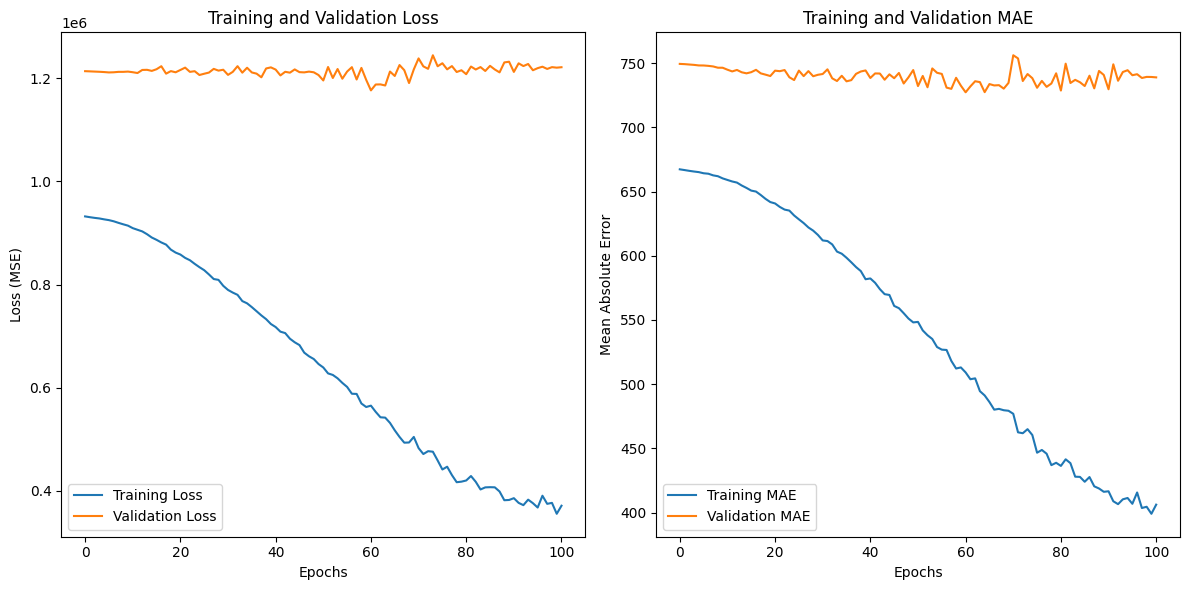

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1063938.5000 - mae: 678.2643
Validation Loss (MSE): 1176262.0000
Validation MAE: 727.3735


In [16]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.title('Training and Validation MAE')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate on validation set
val_loss, val_mae = model.evaluate(X_val, Y_val)
print(f"Validation Loss (MSE): {val_loss:.4f}")
print(f"Validation MAE: {val_mae:.4f}")

###Download the model


In [25]:
# Save the entire model (architecture + weights + optimizer state)
model.save('/content/nba_team_predictor_model.keras')


###Inference Preprocess

In [17]:
X_2023, Y_2023, _, _, team_keys_2023 = preprocess_multiple_teams(
    all_teams_data=data_2023,
    stats_to_remove=unwanted_stats,
    per_game_stats=per_game_stats,
    per_minute_stats=per_minute_stats,
    teams_to_remove=team_year_filters,
    feature_scaler=feature_scaler,
    label_scaler=label_scaler,
    max_players_per_team=max_players
)

print(f"2023 data shape: X={X_2023.shape}, Y={Y_2023.shape}")
print(f"Number of 2023 teams for evaluation: {len(team_keys_2023)}")

2023 data shape: X=(30, 8, 37), Y=(30,)
Number of 2023 teams for evaluation: 30


###Test 2023 Teams

In [18]:
# Make predictions on 2023 data
y_pred_2023 = model.predict(X_2023).flatten()

# Reshape for inverse transform
y_pred_2023_2d = y_pred_2023.reshape(-1, 1)
y_2023_2d = Y_2023.reshape(-1, 1)

# Inverse transform to get original scale
y_pred_2023_original = label_scaler.inverse_transform(y_pred_2023_2d).flatten()
y_2023_original = label_scaler.inverse_transform(y_2023_2d).flatten()

# Calculate error metrics for 2023 data
mae_2023 = mean_absolute_error(y_2023_original, y_pred_2023_original)
rmse_2023 = np.sqrt(mean_squared_error(y_2023_original, y_pred_2023_original))
r2_2023 = r2_score(y_2023_original, y_pred_2023_original)

print(f"\n--- Evaluation on 2023 Data ---")
print(f"Mean Absolute Error: {mae_2023:.2f} points")
print(f"Root Mean Squared Error: {rmse_2023:.2f} points")
print(f"R² Score: {r2_2023:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step

--- Evaluation on 2023 Data ---
Mean Absolute Error: 1168.45 points
Root Mean Squared Error: 1296.41 points
R² Score: -2.3174


###Analyze 2023

In [19]:
results_df = pd.DataFrame({
    'Team': team_keys_2023,
    'Actual Points': y_2023_original,
    'Predicted Points': y_pred_2023_original,
    'Absolute Error': np.abs(y_2023_original - y_pred_2023_original)
})

# Sort by error to see which teams are best/worst predicted
results_df = results_df.sort_values('Absolute Error')
print("\nBest Predicted Teams:")
print(results_df.head(5))
print("\nWorst Predicted Teams:")
print(results_df.tail(5))

# Calculate prediction statistics
pred_min = np.min(y_pred_2023_original)
pred_max = np.max(y_pred_2023_original)
pred_range = pred_max - pred_min
pred_std = np.std(y_pred_2023_original)

print(f"\nPrediction Range: {pred_min:.1f} to {pred_max:.1f} points (range: {pred_range:.1f} points)")
print(f"Prediction Standard Deviation: {pred_std:.2f} points")



Best Predicted Teams:
        Team  Actual Points  Predicted Points  Absolute Error
24  POR_2023         7915.0       7915.038086        0.038086
26  SAS_2023         7489.0       7432.439453       56.560547
22  PHI_2023         8230.0       8012.651855      217.348145
13  LAL_2023         8199.0       7923.026855      275.973145
8   DET_2023         8272.0       7839.170410      432.829590

Worst Predicted Teams:
        Team  Actual Points  Predicted Points  Absolute Error
21  ORL_2023         9136.0       7439.314453     1696.685547
1   BOS_2023         9671.0       7963.675293     1707.324707
19  NYK_2023         9514.0       7730.336914     1783.663086
20  OKC_2023         9633.0       7704.887207     1928.112793
25  SAC_2023         9898.0       7866.156738     2031.843262

Prediction Range: 7432.4 to 8109.1 points (range: 676.7 points)
Prediction Standard Deviation: 197.42 points


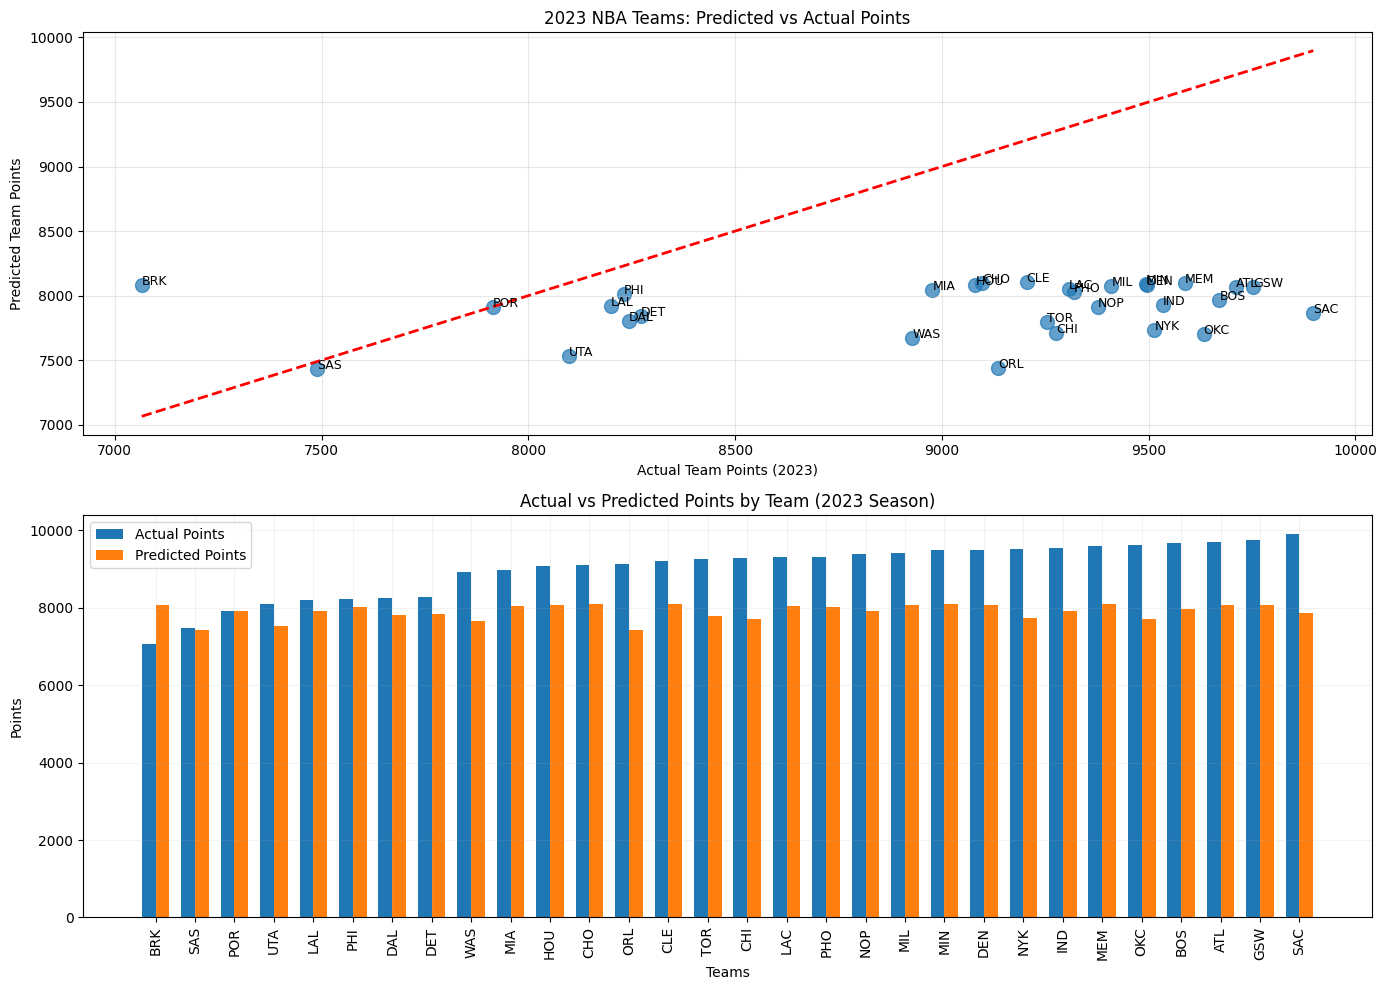

In [20]:
plt.figure(figsize=(14, 10))

# Scatter plot
plt.subplot(2, 1, 1)
plt.scatter(y_2023_original, y_pred_2023_original, alpha=0.7, s=100)
plt.plot([min(y_2023_original), max(y_2023_original)],
         [min(y_2023_original), max(y_2023_original)],
         'r--', linewidth=2)
plt.xlabel('Actual Team Points (2023)')
plt.ylabel('Predicted Team Points')
plt.title('2023 NBA Teams: Predicted vs Actual Points')
plt.grid(True, alpha=0.3)

# Add team labels to the scatter plot
for i, team in enumerate(team_keys_2023):
    team_name = team.split('_')[0]
    plt.annotate(team_name,
                (y_2023_original[i], y_pred_2023_original[i]),
                fontsize=9)

# Bar chart comparing actual and predicted
plt.subplot(2, 1, 2)
x = np.arange(len(team_keys_2023))
width = 0.35

# Sort teams by actual points for better visualization
sorted_indices = np.argsort(y_2023_original)
sorted_teams = [team_keys_2023[i].split('_')[0] for i in sorted_indices]
sorted_actual = y_2023_original[sorted_indices]
sorted_predicted = y_pred_2023_original[sorted_indices]

# Plot bars
plt.bar(x - width/2, sorted_actual, width, label='Actual Points')
plt.bar(x + width/2, sorted_predicted, width, label='Predicted Points')

plt.xlabel('Teams')
plt.ylabel('Points')
plt.title('Actual vs Predicted Points by Team (2023 Season)')
plt.xticks(x, sorted_teams, rotation=90)
plt.legend()
plt.grid(True, alpha=0.15)

plt.tight_layout()
plt.savefig('2023_points_prediction_comparison.png', dpi=300, bbox_inches='tight')
plt.show()